In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sympy as sym

import pycollocation
import pyam

## Defining inputs

Need to define some heterogenous factors of production...

In [3]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': -1.0, 'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [-skill_params['loc1'], 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': -1.0, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [-productivity_params['loc2'], 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )

## Defining a production process

Next need to define some production process...

In [4]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [34]:
# positive assortativity requires that sigma_A * sigma_B > 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.99, 'sigma_B':1.05}

## Define a boundary value problem

In [36]:
problem = pyam.AssortativeMatchingProblem(assortativity='negative',
                                          input1=workers,
                                          input2=firms,
                                          F=F,
                                          F_params=F_params)

## Pick some collocation solver

In [37]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [98]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 50, 'theta': 175},
                                                    exp=0.5)

In [100]:
b = -((np.log(firms.upper) - np.log(firms.lower)) /
      (np.log(workers.upper) - np.log(workers.lower)))
a = firms.lower / workers.upper**b

xs = np.linspace(workers.lower, workers.upper, 1000)
ys = a * xs**b

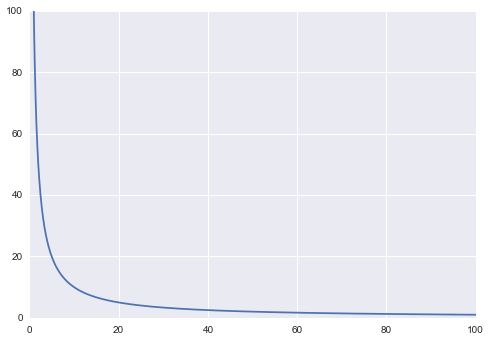

In [101]:
plt.plot(xs, ys)
plt.show()

In [110]:
initial_mu_poly = np.polynomial.Chebyshev.fit(xs, ys, 75, [workers.lower, workers.upper])

In [111]:
thetas = initial_guess._initial_thetas(xs, initial_mu_poly)
initial_theta_poly = np.polynomial.Chebyshev.fit(xs, thetas, 175, [workers.lower, workers.upper])

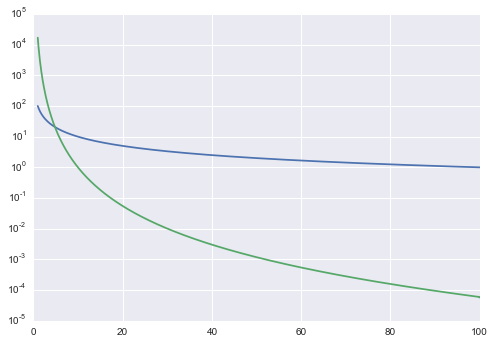

In [112]:
# quickly plot the initial conditions

plt.plot(xs, initial_mu_poly(xs))
plt.plot(xs, initial_theta_poly(xs))
plt.grid('on')
plt.yscale('log')

## Solve the model!

In [126]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_mu_poly.coef,
                 'theta': initial_theta_poly.coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='krylov',
             options={'disp': True})

0:  |F(x)| = 57656.6; step 0; tol 0.9
1:  |F(x)| = 57656.6; step 0; tol 0.9
2:  |F(x)| = 57656.6; step 0; tol 0.9
3:  |F(x)| = 57656.6; step 0; tol 0.9
4:  |F(x)| = 57656.6; step 0; tol 0.9
5:  |F(x)| = 57656.6; step 0; tol 0.9
6:  |F(x)| = 57656.6; step 0; tol 0.9
7:  |F(x)| = 57656.6; step 0; tol 0.9
8:  |F(x)| = 57656.6; step 0; tol 0.9
9:  |F(x)| = 57656.6; step 0; tol 0.9
10:  |F(x)| = 57656.6; step 0; tol 0.9
11:  |F(x)| = 57656.6; step 0; tol 0.9
12:  |F(x)| = 57656.6; step 0; tol 0.9
13:  |F(x)| = 57656.6; step 0; tol 0.9
14:  |F(x)| = 57656.6; step 0; tol 0.9
15:  |F(x)| = 57656.6; step 0; tol 0.9
16:  |F(x)| = 57656.6; step 0; tol 0.9
17:  |F(x)| = 57656.6; step 0; tol 0.9
18:  |F(x)| = 57656.6; step 0; tol 0.9
19:  |F(x)| = 57656.6; step 0; tol 0.9
20:  |F(x)| = 57656.6; step 0; tol 0.9
21:  |F(x)| = 57656.6; step 0; tol 0.9
22:  |F(x)| = 57656.6; step 0; tol 0.9
23:  |F(x)| = 57656.6; step 0; tol 0.9
24:  |F(x)| = 57656.6; step 0; tol 0.9
25:  |F(x)| = 57656.6; step 0; tol 

KeyboardInterrupt: 

In [119]:
solver.result.success

False

## Plot some results

In [120]:
viz = pycollocation.Visualizer(solver)

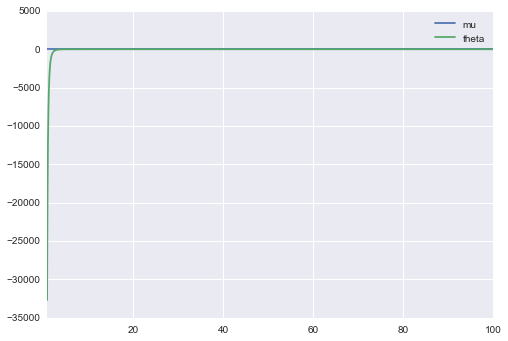

In [121]:
viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
viz.residuals.plot()
plt.show()

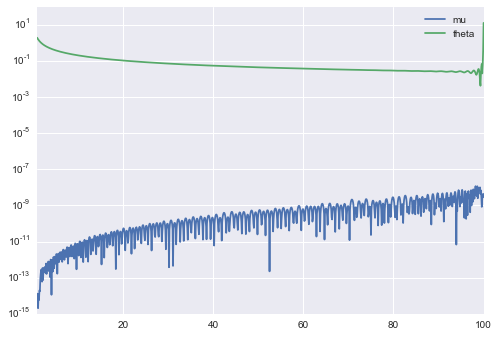

In [122]:
viz.normalized_residuals.plot(logy=True)
plt.show()

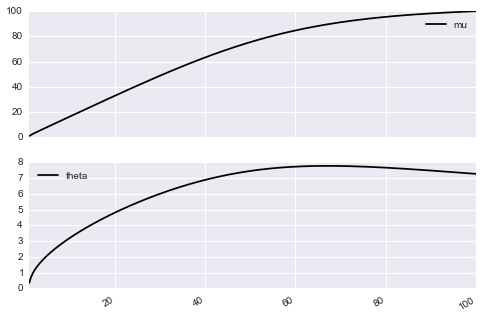

In [15]:
viz.solution.plot(subplots=True)
plt.show()

This is supposed to be the density for firms, but obviously not!

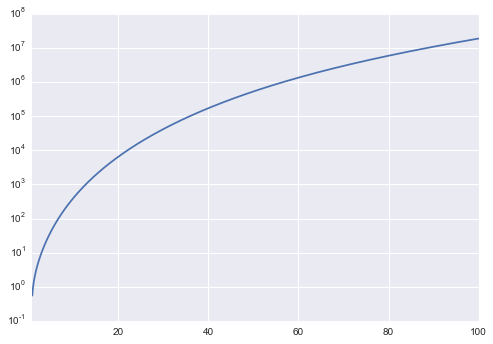

In [19]:
(viz.solution.theta / workers.evaluate_pdf(viz.solution.index.values)).plot(logy=True)
plt.show()

In [20]:
solver._coefs_array_to_dict(solver.result.x, solver._degrees)

{'mu': array([  6.23372475e+01,   4.99918669e+01,  -1.25498302e+01,
         -6.95367288e-01,   9.58749142e-01,   8.83914094e-02,
         -1.60494451e-01,   2.75045026e-02,  -6.85480144e-03,
          2.10783153e-02,  -2.16431269e-02,   1.66324809e-02,
         -1.37052646e-02,   1.20902344e-02,  -1.05365807e-02,
          9.05323189e-03,  -7.80035553e-03,   6.75227141e-03,
         -5.85248518e-03,   5.07644939e-03,  -4.41003350e-03,
          3.83772729e-03,  -3.34504711e-03,   2.92020615e-03,
         -2.55345625e-03,   2.23646258e-03,  -1.96210861e-03,
          1.72435968e-03,  -1.51809325e-03,   1.33894785e-03,
         -1.18320466e-03,   1.04768967e-03,  -9.29690124e-04,
          8.26883696e-04,  -7.37279048e-04,   6.59165613e-04,
         -5.91070990e-04,   5.31724573e-04,  -4.80026094e-04,
          4.35018138e-04,  -3.95862561e-04,   3.61819341e-04,
         -3.32221770e-04,   3.06448901e-04,  -2.83921785e-04,
          2.64114125e-04,  -2.46426779e-04,   2.29982497e-04,
  

In [24]:
problem.params

OrderedDict([('loc1', -1.0), ('loc2', -1.0), ('mu1', 0.0), ('mu2', 0.0), ('omega_A', 0.25), ('omega_B', 0.5), ('sigma1', 1.0), ('sigma2', 1.0), ('sigma_A', 0.5), ('sigma_B', 1.0)])

In [27]:
problem.input1.params['sigma1'] = 0.5

In [28]:
problem.params

OrderedDict([('loc1', -1.0), ('loc2', -1.0), ('mu1', 0.0), ('mu2', 0.0), ('omega_A', 0.25), ('omega_B', 0.5), ('sigma1', 0.5), ('sigma2', 1.0), ('sigma_A', 0.5), ('sigma_B', 1.0)])